In [1]:
!pip install -q tensorflow-hub
!pip install -q gensim
!pip install -q sklearn
!pip install -q matplotlib
!apt-get install -qq jq
!wget -nc -c https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec

File ‘wiki.en.vec’ already there; not retrieving.



Download and unpack the annotations from the 2014 MSCOCO dataset. This has 100k+ human-entered image captions. Each is a short declarative sentence. 

This dataset has shallow linguistic depth but a lot of vocabulary.

**jq** is a super-fast streaming JSON parser app.

In [0]:
!wget -c -nc -q http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip -p annotations_trainval2014.zip annotations/captions_train2014.json > captions_train2014.json
!jq -r '.annotations[]|.caption' < captions_train2014.json > sentences.txt

In [3]:
import pickle
import os
import itertools
import numpy as np
from scipy import spatial
from scipy.stats import norm
from sklearn.decomposition import PCA
import nltk.data
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import reuters
from nltk. corpus import gutenberg
from nltk.corpus import brown
from nltk.tokenize import sent_tokenize
from gensim.models import KeyedVectors
from gensim.models import FastText
from keras.layers import Input, Dense, Lambda, Layer
from keras.optimizers import Adam, Nadam
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras import backend as K
from keras import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('brown')
nltk.download('reuters')
nltk.download('gutenberg')

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

# Preprocessing Text

The preprocessing code is data specific.  
  
It is an example of how one can use a pre-trained word2vec to embed sentences into a vector space.

In [4]:
# A little tight on RAM, so parse word2vec, save object to disk, memory-map object back into RAM.
# Now the OS can drop the space whenever it is not being read.
w2v = None
max_words=100000
#!rm -f /content/wiki.en.vec.kv
!date
if not os.path.exists('/content/wiki.en.vec.kv'):
    print('Read word2vec vectors from text')
    w2v = KeyedVectors.load_word2vec_format('/content/wiki.en.vec', limit=max_words)
    print('Save word2vec vectors to cache')
    w2v.save('/content/wiki.en.vec.kv')
else:
    print('Using cached word2vec vectors')
    w2v = KeyedVectors.load('/content/wiki.en.vec.kv', mmap='r')
!date
embedding_size = 300
sentence_length = 10

Mon Dec 17 05:14:55 UTC 2018
Using cached word2vec vectors
Mon Dec 17 05:14:58 UTC 2018


In [5]:
!ls -ld /content
!ls -l /content

drwxr-xr-x 1 root root 4096 Dec 17 03:54 /content
total 6993828
-rw-r--r-- 1 root root   10942847 Dec 17 03:40 10words.pk
-rw-r--r-- 1 root root  252872794 Jul 10 17:58 annotations_trainval2014.zip
-rw-r--r-- 1 root root   66782097 Dec 17 05:14 captions_train2014.json
-rw-r--r-- 1 root root   86495096 Dec 17 04:04 model.h5
drwxr-xr-x 1 root root       4096 Dec 10 17:34 sample_data
-rw-r--r-- 1 root root   22159544 Dec 17 05:14 sentences.txt
-rw-r--r-- 1 root root 6597238061 May  2  2017 wiki.en.vec
-rw-r--r-- 1 root root    5160484 Dec 17 03:40 wiki.en.vec.kv
-rw-r--r-- 1 root root  120000128 Dec 17 03:40 wiki.en.vec.kv.vectors.npy


In [0]:
def token_sent (text):
    strg_cleaned = text.lower()
    for x in ['\xd5d','\n','"',"!", '#','$','%','&','(',')','*','+',',','-','/',':',';','<','=','>','?','@','[','^',']','_','`','{','|','}','~','\t']:
        strg_cleaned = strg_cleaned.replace(x, '')
    sentences = sent_tokenize(strg_cleaned)
    return sentences

In [0]:
def wordify(sentence):
    if sentence[-1] == '.':
        sentence = sentence[:-1]
    byword = sentence.split()
    for word in byword:
        if not word in w2v:
            return None
    return byword

def vectorize_sentence(sentence):
    vector = []
    for word in sentence:
        vector.append(w2v[word])
    return vector
        

Preprocessing text from a variety of different sources.

It's important to shuffle the text vectors before splitting them into test and train samples.   
  
This is done to avoid clumping text with similar context and style in the dataset because it can confuse the neural network during training.load_word2vec_format

In [8]:
data_concat = []
#!rm -f /content/10words.pk
if not os.path.exists('/content/10words.pk'):
    data_concat = []
    total = 0
    found = 0
    with open('sentences.txt', 'r') as f:
        for line in f:
            total += 1
            line = line.strip()
            if line.count(' ') != 9:
                continue
            text_array = token_sent(line)
            for sentence in text_array:
                vect = wordify(sentence)
                if vect != None and len(vect) == 10:
                    data_concat.append(vect)

    with open('/content/10words.pk', 'wb') as f:
        pickle.dump(data_concat, f)
else:
    with open('/content/10words.pk', 'rb') as f:
        data_concat = pickle.load(f)
print('Total # of 10-word sentences: {}'.format(len(data_concat)))

Total # of 10-word sentences: 82191


In [0]:
train = data_concat[10000:]
test = data_concat[:10000]
np.random.shuffle(train)
np.random.shuffle(test)
train = np.array(train)
test = np.array(test)
#del data_concat

# sentences = [['a', 'word', ..., 'word'],[...]]
def vectorize_batch(sentences):
    batch_features = np.zeros((batch_size, embedding_size * len(sentences[0])))
    for i in range(batch_size):
         batch_features[i] = np.reshape(np.array(vectorize_sentence(sentences[i])), embedding_size * len(sentences[0]))
    return batch_features
            
#add randomization of batch
#model.fit_generator(generator(features, labels, batch_size), samples_per_epoch=50, nb_epoch=10
def generator(sentences, batch_size):
    index = 0
    while True:
        batch_features = np.zeros((batch_size, embedding_size * len(sentences[0])))
        for i in range(batch_size):
            batch_features[i] = np.reshape(np.array(vectorize_sentence(sentences[index + i])), embedding_size * len(sentences[0]))
        index += batch_size
        if index >= len(sentences):
            index = 0
        yield batch_features, batch_features
        

# Variational Autoencoder

In [13]:
batch_size = 500
original_dim = 3000
latent_dim = 1000
intermediate_dim = 1200
epochs=250
epsilon_std = 1.0
learning_rate = 0.001
opt = Nadam(lr=learning_rate)


# Can only train on batch_size modulo data
train = train[:(len(train) // batch_size) * batch_size]
test = test[:(len(test) // batch_size) * batch_size]

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# placeholder loss
def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)

# KL loss as an accuracy measure
def kl_acc(x, x_decoded_mean):
    return -0.5 + K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)/original_dim

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)
        
    def vae_loss(self, x, x_decoded_mean):
        xent_loss = metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(original_dim * xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # we don't use this output, but it has to have the correct shape:
        return K.ones_like(x)

loss_layer = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, [loss_layer])
vae.compile(optimizer='rmsprop', loss=[zero_loss], metrics=[kl_acc])
vae.summary()

#checkpoint
cp = [ModelCheckpoint(filepath="/content/model.h5", verbose=1, save_best_only=True)]

print('Training with {} training samples, {} test samples'.format(len(train), len(test)))
#train
!rm -f /content/model.h5
if os.path.exists('/content/model.h5'):
    vae.load_weights('/content/model.h5')
    history = None
else:
    history = vae.fit_generator(generator(train, batch_size),
        shuffle=True,
        epochs=epochs,
        steps_per_epoch=len(train)/batch_size,
        validation_steps=len(test)/batch_size,
        verbose=2,
        validation_data=generator(test, batch_size), 
        callbacks=cp)

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (500, 3000)          0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (500, 1200)          3601200     input_4[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (500, 1000)          1201000     dense_16[0][0]                   
__________________________________________________________________________________________________
dense_18 (Dense)                (500, 1000)          1201000     dense_16[0][0]                   
__________________________________________________________________________________________________
lambda_4 (

## Plot the training curves

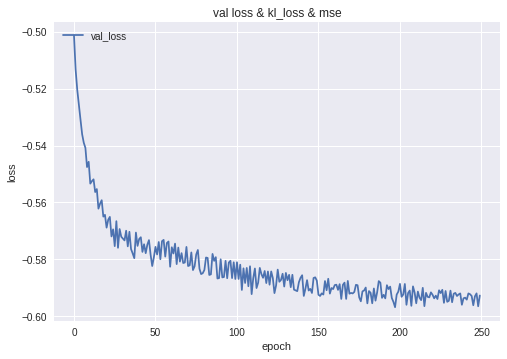

In [16]:
import sklearn.preprocessing as skprep 

if history != None:
    #plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_kl_acc'])
    #plt.plot(history.history['val_mean_squared_error'])
    plt.title('val loss & kl_loss & mse')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'val_kl_acc', 'val_mse'], loc='upper left')
    plt.show()


# Generating Text From Latent Space

In [0]:
# Assume sentence is kosher
def sent_parse(sentence, mat_shape):
    data_concat = []
    word_vecs = vectorize_sentence(wordify(sentence))
    for x in word_vecs:
        data_concat.append(list(itertools.chain.from_iterable(x)))
    zero_matr = np.zeros(mat_shape)
    zero_matr[0] = np.array(data_concat)
    return zero_matr

In [0]:
# input: original dimension sentence vector
# output: text
def print_sentence_with_w2v(sent_vect):
    word_sent = ''
    tocut = sent_vect
    for i in range (int(len(sent_vect)/300)):
        word_sent += w2v.most_similar(positive=[tocut[:300]], topn=1)[0][0]
        word_sent += ' '
        tocut = tocut[300:]
    print(word_sent)

In [0]:
# input: encoded sentence vector
# output: encoded sentence vector in dataset with highest cosine similarity
def find_similar_encoding(sent_vect):
    all_cosine = []
    for sent in sent_encoded:
        result = 1 - spatial.distance.cosine(sent_vect, sent)
        all_cosine.append(result)
    data_array = np.array(all_cosine)
    maximum = data_array.argsort()[-3:][::-1][1]
    new_vec = sent_encoded[maximum]
    return new_vec

In [0]:
# input: two points, integer n
# output: n equidistant points on the line between the input points (inclusive)
def shortest_homology(point_one, point_two, num):
    dist_vec = point_two - point_one
    sample = np.linspace(0, 1, num, endpoint = True)
    hom_sample = []
    for s in sample:
        hom_sample.append(point_one + s * dist_vec)
    return hom_sample

In [0]:
# input: two written sentences, VAE batch-size, dimension of VAE input
# output: the function embeds the sentences in latent-space, and then prints their generated text representations
# along with the text representations of several points in between them
def sent_2_sent(sent1,sent2, batch, dim):
    a = sent_parse([sent1], (batch,dim))
    b = sent_parse([sent2], (batch,dim))
    encode_a = encoder.predict(a, batch_size = batch)
    encode_b = encoder.predict(b, batch_size = batch)
    test_hom = hom_shortest(encode_a[0], encode_b[0], 5)
    
    for point in test_hom:
        p = generator.predict(np.array([point]))[0]
        print_sentence(p)

Printing sentences from the training set and comparing them with the original will test whether the custom print function works properly.

In [31]:
print_sentence_with_w2v(train[1])
print_sentence_with_w2v(train[2])

The encoder takes the test set of sentence vectors (concatenanted word vectors) and embeds them into a lower dimensional vector space.

In [0]:
 
sent_embedded = vectorize_batch(train[:10000])
sent_encoded = encoder.predict(sent_embedded, batch_size = 500)

The decoder takes the list of latent dimensional encodings from above and turns them back into vectors of their original dimension.

In [0]:
sent_decoded = generator.predict(np.array(sent_encoded), batch_size=500)

The encoder trained above embeds sentences (concatenated word vetors) into a lower dimensional space. The code below takes two of these lower dimensional sentence representations and finds five points between them. It then uses the trained decoder to project these five points into the higher, original, dimensional space. Finally, it reveals the text represented by the five generated sentence vectors by taking each word vector concatenated inside and finding the text associated with it in the word2vec used during preprocessing.

In [34]:
test_hom = shortest_homology(sent_encoded[3], sent_encoded[10], 5)
for point in test_hom:
    p = generator.predict(np.array([point]))[0]
    print_sentence_with_w2v(p)

a cow with several hooves in a pulling of animals 


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


a goat with many forearms in a and of animals 
a dog and that with the the and the animals 
a little boy looks with a bat in shortstops books 
a little boy poses with a bat in baseball books 


The code below does the same thing, with one important difference. After sampling equidistant points in the latent space between two sentence embeddings, it finds the embeddings from our encoded dataset those points are most similar to. It then prints the text associated with those vectors.
  
This allows us to explore how the Variational Autoencoder clusters our dataset of sentences in latent space. It lets us investigate whether sentences with similar concepts or grammatical styles are represented in similar areas of the lower dimensional space.

In [35]:
test_hom = shortest_homology(sent_encoded[2], sent_encoded[400], 20)
for point in test_hom:
    p = generator.predict(np.array([find_similar_encoding(point)]))[0]
    print_sentence_with_w2v(p)

a couple of people are flying kites on the beach 


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


a couple of people are flying kites on the beach 
a couple of people are flying kites on the beach 
a couple of people are flying kites on the beach 
a couple of people are flying kites on the beach 
a baseball player is swinging a bat and some comebacks 
a baseball player is swinging a bat and some comebacks 
a baseball player is swinging a bat and some comebacks 
a baseball player is swinging a bat and some comebacks 
a baseball player is swinging a bat and some comebacks 
a number of people with surf board on a beach 
a number of people with surf board on a beach 
a number of people with surf board on a beach 
a baseball player is holding a bat above his head 
a baseball player is holding a bat above his head 
a baseball player is holding a bat above his head 
a baseball player is holding a bat above his head 
a baseball player is holding a bat above his head 
a baseball player is holding a bat above his head 
a baseball player is holding a bat above his head 


# Visualization

## Plot Original and Variational embeddings
First, create a 2D visualization of the embedding space. Use Principal Components Analysis (PCA) to project N-dimensional space to 2 dimensions. PCA creates an n-dimensional rotation that optimizes for the largest standard deviation in column 0, second largest stdev in column 1, and so on. Using the first two columns as X and Y in a scatter plot gives a decent 2D representation of the embedding space.

In [36]:
pca_orig = PCA(n_components=2)
pca_orig.fit(sent_embedded)
pca_predict = PCA(n_components=2)
pca_predict.fit(sent_encoded)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

## Create a small test set of similar sentences, and project via PCA.
These sentences are adapted from the famous "twisty maze of passages" from the very first text adventure game, "Adventure". There are 5 from the original set,  another four that are somewhat varied, and a final outlier.

In [0]:
adventure = [
    'you are in a twisty little maze of passages now',
    'you are in a twisting maze of little passages now',
    'you are in a little twisty maze of passages now',
    'you are in a maze of little twisting passages now',
    'you are in a maze of little twisty passages now'
]
freestyle = [
    'before you is a twisty maze of passages all different',
    'you see now a twisty maze of passages all alike',
    'a maze of twisty passages all the same stretches out',
    'twisty passages forming a maze stretch in front of you'
]
more_free = [
        'a twisty maze all quite self similar lies before you'
]
    
def predict(sentences):
    embeds = []
    for sentence in sentences:
        v = vectorize_sentence(wordify(sentence))
        embeds.append(np.reshape(v, (3000)))
    orig = np.array(embeds)
    predicted = np.array(encoder.predict(orig, batch_size = 1))
    return (orig, predicted)

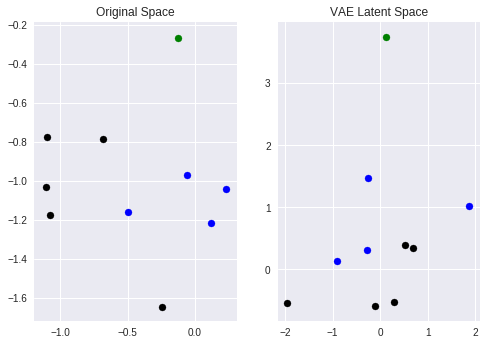

In [38]:

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.set_title('Original Space')
ax2.set_title('VAE Latent Space')
#ax1.set(adjustable='box-forced', aspect='equal')
#ax2.set(adjustable='box-forced', aspect='equal')
(orig, predicted) = predict(adventure)
for xy in pca_orig.transform(orig):
    ax1.scatter(xy[0], xy[1], color='black')
for xy in pca_predict.transform(predicted):
    ax2.scatter(xy[0], xy[1], color='black')
(orig, predicted) = predict(freestyle)
for xy in pca_orig.transform(orig):
    ax1.scatter(xy[0], xy[1], color='blue')
for xy in pca_predict.transform(predicted):
    ax2.scatter(xy[0], xy[1], color='blue')
(orig, predicted) = predict(more_free)
for xy in pca_orig.transform(orig):
    ax1.scatter(xy[0], xy[1], color='green')
for xy in pca_predict.transform(predicted):
    ax2.scatter(xy[0], xy[1], color='green')


In these plots, the sentences from Adventure are in black,  'Freestyle' versions are in blue, and a single green dot is a variation which is slightly more free-spirited.

## Heatmaps

In [0]:
def plot_similarity(labels, features, rotation):
  corr = np.zeros((len(features), len(features)))
  for i in range(len(features)):
    for j in range(len(features)):
        corr[i][j] = np.sqrt(spatial.distance.cosine(features[i], features[j]))
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0.0,
      vmax=1.0,
      cmap="YlOrRd"
  )

  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity (cosine distance)")
    
misc_text = [
    "a motorcycle badly parked in a very long grass driveway",
    "my motorcycle is parked on the gravel behind a driveway",
    "a black motorcycle parked sideways in front of a garage",
    "a motorcycle with its brake extended standing outside a garage"
]


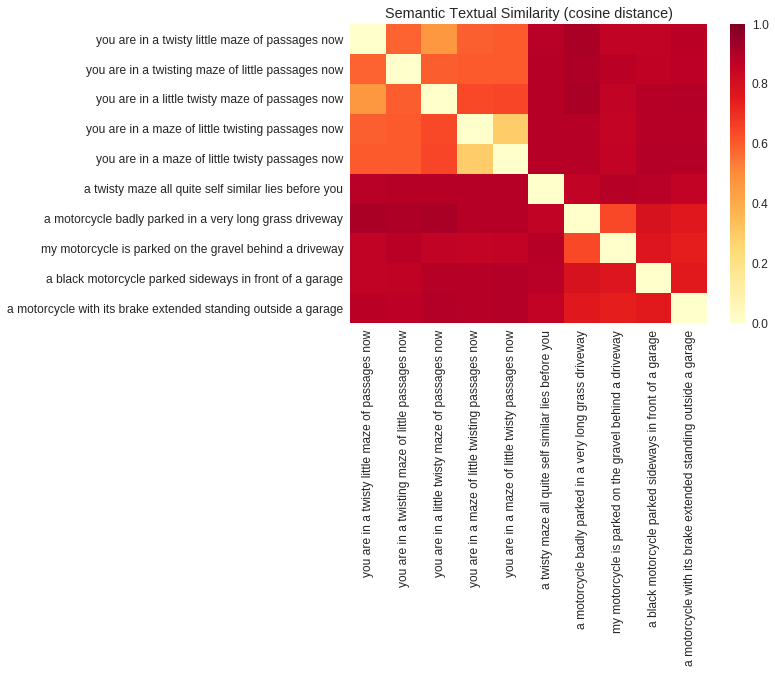

In [40]:
#labels = adventure + freestyle + more_free 
labels = adventure + more_free + misc_text
(orig, predicted) = predict(labels)
plot_similarity(labels, orig, 90)

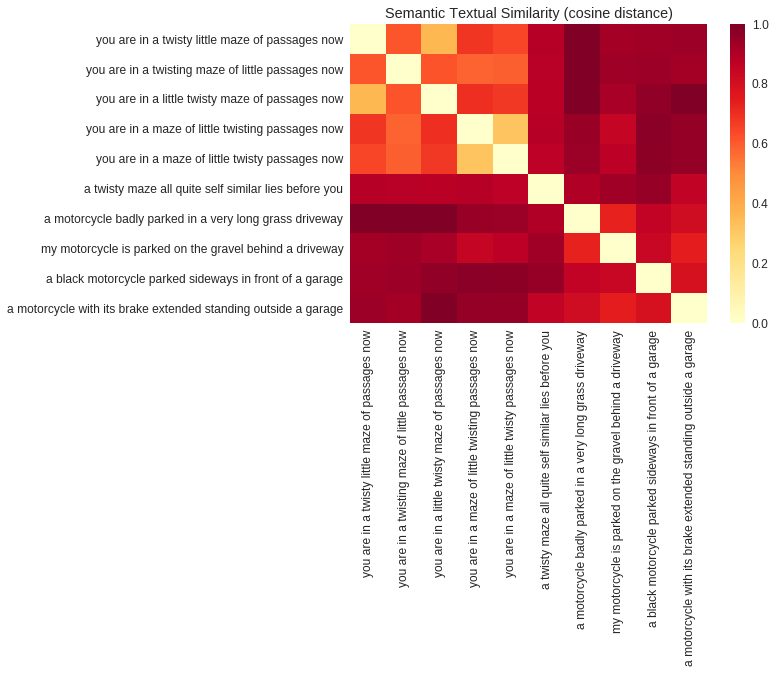

In [42]:
plot_similarity(labels, predicted, 90)